# Transfer Learning from Pre-Trained Models  

Instead of starting from randomly initialised weights, transfer learning allows you to start with weights from a pre-trained neural network to learn something new.

This notebook walkthrough transfer learning from a [VGG11](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html) model trained on [the imagenet dataset](https://www.image-net.org/). There are a lot of pre-trained models in the [torchvision models library](https://pytorch.org/vision/stable/models.html), feel free to explore other options.

In [13]:
import torch

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

elif torch.backends.mps.is_available():
    device = "mps"

print(f'Using device: {device}')

Using device: mps


## **Step 1** - Prepare Dataset

We'll use the [Flower Recognition](https://aiplanet.com/challenges/61/data-sprint-25-flower-recognition-61/data) dataset again, but this time we'll use images with higher-resolution.

If you haven't done this:
<u>Please download the dataset from [here](https://drive.google.com/file/d/1v0or9w-z4x0M0SHNFkp9UVZGsJ1G6e_t/view?usp=sharing) and unzip it to the `class-4` folder.</u>

In [14]:
# we choose 224 because this is the input resolution of the VGG16 model
image_resolution = 224 

# how many colour channels?
# 3 for RGB, 1 for greyscale
colour_channels = 3

# make sure the path to your image folder is correct
folder_path = './flowers_n/train'

#### **1.1** - Pre-process images 

Pre-process (i.e. crop, resize, normalise) the images in our dataset.

Use [PyTorch's Transforming functions](https://pytorch.org/vision/0.17/transforms.html) to define the pre-processes pipeline on our images. 


In [15]:
from torchvision.transforms.v2 import Compose, ToImage, ToDtype, Grayscale, Resize, RandomCrop, Normalize

# this transformation function will help us pre-process images during the training (on-the-fly)
transformation = Compose([   
    # convert an image to tensor
    ToImage(),
    ToDtype(torch.float32, scale=True),
    
    # resize and crop
    Resize(image_resolution),
    RandomCrop(image_resolution),
    
    # normalise pixel values to be between -1 and 1 
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
    # if you're training on greyscale images, convert them to greyscale
    # otherwise just do nothing
    Grayscale() if colour_channels == 1 else torch.nn.Identity()
    
])

#### **1.2** - Create dataset loaders  

Data loaders loads images into batches according to the pre-processes pipeline we have defined previously.

In [16]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import torch
import torchvision

from torch import nn

from IPython.display import display

from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid

In [17]:
# how many images are going to be put into the testing set, 
# e.g. 0.2 means 20% percent of images
test_size = 0.2 

# how many images will be used in one epoch, 
# this usually depend on your model / types of data / CPU or GPU's capability
batch_size = 16

In [18]:
# Instatiate train and test datasets
train_dataset = ImageFolder(folder_path, transform=transformation)
test_dataset = ImageFolder(folder_path, transform=transformation)

# Get length of dataset and indicies
num_train = len(train_dataset)
indices = list(range(num_train))

# Get train / test split for data points
train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=42)

# Override dataset classes to only be samples for each split
train_sub_dataset = torch.utils.data.Subset(train_dataset, train_indices)
test_sub_dataset = torch.utils.data.Subset(test_dataset, test_indices)

# Create training and tresing data loaders
train_loader = DataLoader(train_sub_dataset, batch_size=batch_size, num_workers=4, multiprocessing_context="forkserver" if device=='mps' else None, shuffle=True)
test_loader = DataLoader(test_sub_dataset, batch_size=batch_size, num_workers=4, multiprocessing_context="forkserver" if device=='mps' else None, shuffle=True)


In [19]:
# sort out the names for each classes (according to the folder names)
class_names = train_dataset.classes

print(f'{len(train_indices)} training images loaded')
print(f'{len(test_indices)} testing images loaded')
print(f'classes: {class_names}')

data, labels = next(iter(train_loader))

print(f'data shape: {data.shape}')
print(f'labels shape: {labels.shape}')

2196 training images loaded
550 testing images loaded
classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
data shape: torch.Size([16, 3, 224, 224])
labels shape: torch.Size([16])


## **Step 2** - Load the pre-trained model  

Load the pre-trained VGG11 model from [the torchvision models library](https://pytorch.org/vision/stable/models.html). 

We are going to do **transfer learning** with this model, which means we are going to start with a trained model rather than a brand new model with random weights.

One approach, like we saw in lecture, is to throw away one or more final layers of the original network, and then train new layers to learn the relationship between the activations in the original network and the desired outputs for some new data. (We might also call this "feature learning"). 

Another approach is to take the original network and adjust its weights on some new data. This means that we'll start with the pre-trained model's weight values, rather than start with random weight values, and we will adjust some or all of these values gradually to try to model a new dataset. 

Both of these transfer learning approaches can work well when you have an existing model that has learned to model something well, and you'd like it to learn to model something slightly different.

In this notebook, we'll start by freezing all model parameters (weights) before the last two fully connected layers (i.e. `Linear` layer), and swap the last two fully connected layers with a new `Linear` layer (which will be trained on our new data).

We can iterate through all model parameters and set the `requires_grad` attribute to `False`, in this way they are 'freezed', and won't be updated during training.


In [20]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Run this cell if you want to freeze all model parameters in the original network (e.g. because you are replacing the last layers entirely). Or, skip this step if you want to instead fine-tune all weights in the network to reflect the new data.**

In [21]:
# freeze all model parameters
for param in model.parameters():
    param.requires_grad = False

Replace the last two fully connected layers with new ones:

In [22]:
# replace the last two fully connected layers with new ones.
# model.classifier[3] = nn.Linear(model.classifier[3].in_features, 256)
# model.classifier[6] = nn.Linear(256, 5)
model.fc = nn.Linear(model.fc.in_features, 5)


model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## **Step 3** - Train the model

Now we can used the training workflow to train the model



#### Define optimiser and loss function

In [23]:
# Cross entropy loss
loss_function = torch.nn.CrossEntropyLoss().to(device)

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters())

#### Define training/ testing loop  

In [24]:
# we can save the model regularly
save_every_n_epoch = 5

# total number of epochs we aim for
num_epochs = 10

# keep track of the losses, we can plot them in the end
train_losses = []
test_losses = []

print('Epoch 0')

for epoch in range(num_epochs): 

    #---- Training loop -----------------------------
    train_loss = 0.0
    model.train()
    
    for i, data in enumerate(train_loader, 0):
        # Load: The training data loader loads a batch of training data and their true class labels.
        inputs, true_labels = data
        inputs = inputs.to(device)
        true_labels = true_labels.to(device)
        
        # Pass: Forward pass the training data to our model, and get the predicted classes.
        pred_labels = model(inputs)
        
        # Loss: The loss function compares the predicted classes to the true classes, and calculates the error.
        loss = loss_function(pred_labels, true_labels)
        train_loss += loss.item()
        
        # Optimise: The optimizer slightly optimises our model based on the error.
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if i % 50 == 0:
            print(f'  -> Step {i + 1:04}, train loss: {loss.item():.4f}')
    
    
    #---- Testing loop -----------------------------
    test_loss = 0.0
    model.eval()
    
    with torch.inference_mode():
        test_loss = 0.0
        for i, data in enumerate(test_loader, 0):
            # Load: The testing data loader loads a batch of testing data and their true class labels.
            inputs, true_labels = data
            inputs = inputs.to(device)
            true_labels = true_labels.to(device)
            
            # Pass: Forward pass the testing data to our model, and get the predicted classes.
            pred_labels = model(inputs)
            
            # Loss: The loss function compares the predicted classes to the true classes, and calculates the error.
            loss = loss_function(pred_labels, true_labels)
            test_loss += loss.item()
    
    
    #---- Report some numbers -----------------------------
    
    # Calculate the cumulative losses in this epoch
    train_loss = train_loss / len(train_loader)
    test_loss = test_loss / len(test_loader)
    
    # Added cumulative losses to lists for later display
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch + 1}, train loss: {train_loss:.3f}, test loss: {test_loss:.3f}')
    
    # save our model every n epoch
    if (epoch+1) % save_every_n_epoch==0:
        torch.save(model.state_dict(), f'model_epoch{epoch:04}.pt')
        
# save the model at the end of the training process
torch.save(model.state_dict(), f'model_final.pt')

print("training finished, model saved to 'model_final.pt'")

Epoch 0
  -> Step 0001, train loss: 1.7915
  -> Step 0051, train loss: 0.9949
  -> Step 0101, train loss: 0.7312
Epoch 1, train loss: 0.906, test loss: 0.475
  -> Step 0001, train loss: 0.7400
  -> Step 0051, train loss: 0.6926
  -> Step 0101, train loss: 0.5101
Epoch 2, train loss: 0.518, test loss: 0.378
  -> Step 0001, train loss: 0.5306
  -> Step 0051, train loss: 0.6323
  -> Step 0101, train loss: 0.7164
Epoch 3, train loss: 0.439, test loss: 0.308
  -> Step 0001, train loss: 0.5268
  -> Step 0051, train loss: 0.3536
  -> Step 0101, train loss: 0.4125
Epoch 4, train loss: 0.383, test loss: 0.304
  -> Step 0001, train loss: 0.3010
  -> Step 0051, train loss: 0.3752
  -> Step 0101, train loss: 0.2109
Epoch 5, train loss: 0.356, test loss: 0.281
  -> Step 0001, train loss: 0.0978
  -> Step 0051, train loss: 0.3002
  -> Step 0101, train loss: 0.2190
Epoch 6, train loss: 0.350, test loss: 0.255
  -> Step 0001, train loss: 0.5062
  -> Step 0051, train loss: 0.2261
  -> Step 0101, train 

#### Plot Training Process


In [25]:
import matplotlib.pyplot as plt
import numpy as np

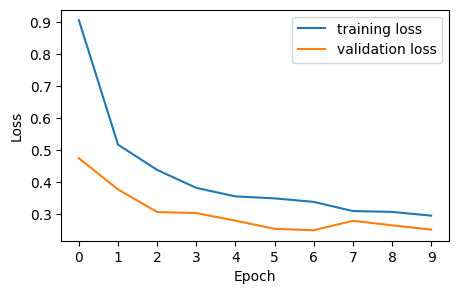

In [26]:
plt.figure(figsize=(5,3))
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label = 'validation loss')
plt.xticks(np.arange(len(train_losses)))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

## **Step 4** - Calculate accuracy  

Now we can run our model on the full testing set to calculate the accuracy of our model.  

Compare the result with the model that we trained from scratch in the first notebook. Does the accuracy improve?

In [27]:
num_samples = 0
num_correct = 0

with torch.inference_mode():
    for i, data in enumerate(test_loader, 0):
        # Load: The testing data loader loads a batch of testing data and their true class labels.
        inputs, true_labels = data
        inputs = inputs.to(device)
        true_labels = true_labels.to(device)

        # Pass: Forward pass the testing data to our model, and get the predicted classes.
        pred_labels = model(inputs)
        pred_labels = torch.argmax(pred_labels, dim=1)
        
        num_correct += pred_labels.size(0) - torch.count_nonzero(pred_labels - true_labels)
        num_samples += pred_labels.size(0) 
        
accuracy = num_correct / num_samples
print(f'correct samples: {num_correct}  \ntotal samples: {num_samples}  \nmodel accuracy: {accuracy:.3f}')

correct samples: 493  
total samples: 550  
model accuracy: 0.896


## Tasks

After you went through all the code in this notebook, **make a copy of this notebook** before working on the tasks so that we can have a direct comparison of the results.

### Task 1
Look at other models from the [PyTorch model library](https://pytorch.org/vision/stable/models.html), choose a different pre-trained model (e.g. ResNet18), load it, freeze the weights, and swap the last one or two fully connected layers (just like what we have did for the VGG11 model). Train the model and compare the results (e.g. which model converges faster? Does the accuracy improve?)

#### VGG11
model accuracy: 0.918

#### ResNet18
model accuracy: 0.896

#### ResNet50
crash





### Bonus Task
Re-run the code and try out the alternative approach of fine-tuning **all** weights in the network rather than only learning a new final layer (check their differences in Step 2). This means you will skip the step that freezes model parameters for fine-tuning. How do the result and the training process compare? Is this approach converge noticeably slower?